In [231]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [232]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [233]:
df = pd.read_csv('/content/sample_data/radish_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [234]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,3714.0,1172345,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,3782.0,1172345,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,3782.0,1172345,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,3920.0,1172345,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,3970.0,1172345,0,0,0,1


In [235]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]

scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.24351879 0.         0.61403509 ... 1.         0.         0.        ]
 [0.24876202 0.         0.36842105 ... 0.         1.         0.        ]
 [0.23507137 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.79667929 0.         0.19298246 ... 1.         0.         0.        ]
 [0.83687737 0.         0.12280702 ... 0.         1.         0.        ]
 [0.85144189 0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [236]:
# 7일치의 input으로 7일치의 output을 생산
seq_length = 7
predict_day = 7
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2381
2381


In [237]:
# 7의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1428
validation_size = 476
test_size = 476

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1428, 7, 10)
(1428, 7, 1)
(476, 7, 10)
(476, 7, 1)
(476, 7, 10)
(476, 7, 1)


In [238]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [239]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [240]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(7, 7, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (7, 7, 16)                1728      
                                                                 
 lstm_17 (LSTM)              (7, 7, 16)                2112      
                                                                 
 dense_8 (Dense)             (7, 7, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [241]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-radish.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [242]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [243]:
custom_hist = CustomHistory()
custom_hist.init()

In [244]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=7, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
204/204 - 5s - loss: 0.0220 - mae: 0.1201 - val_loss: 0.0943 - val_mae: 0.2799 - 5s/epoch - 24ms/step
epochs:1
204/204 - 1s - loss: 0.0179 - mae: 0.1026 - val_loss: 0.0602 - val_mae: 0.2269 - 1s/epoch - 6ms/step
epochs:2
204/204 - 1s - loss: 0.0155 - mae: 0.0937 - val_loss: 0.0515 - val_mae: 0.2106 - 1s/epoch - 6ms/step
epochs:3
204/204 - 1s - loss: 0.0141 - mae: 0.0889 - val_loss: 0.0488 - val_mae: 0.2056 - 1s/epoch - 6ms/step
epochs:4
204/204 - 1s - loss: 0.0128 - mae: 0.0830 - val_loss: 0.0424 - val_mae: 0.1918 - 1s/epoch - 5ms/step
epochs:5
204/204 - 1s - loss: 0.0114 - mae: 0.0786 - val_loss: 0.0331 - val_mae: 0.1687 - 1s/epoch - 6ms/step
epochs:6
204/204 - 1s - loss: 0.0110 - mae: 0.0759 - val_loss: 0.0340 - val_mae: 0.1711 - 978ms/epoch - 5ms/step
epochs:7
204/204 - 1s - loss: 0.0107 - mae: 0.0741 - val_loss: 0.0415 - val_mae: 0.1900 - 1s/epoch - 6ms/step
epochs:8
204/204 - 1s - loss: 0.0100 - mae: 0.0722 - val_loss: 0.0358 - val_mae: 0.1760 - 1s/epoch - 5ms/step
epochs

In [246]:
a = 7

In [247]:
model.evaluate(trainX, trainY, batch_size = a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0042 - mae: 0.0439


[0.004234601277858019, 0.04392339661717415]

In [248]:
print(custom_hist.train_loss)

[0.02200271189212799, 0.017859023064374924, 0.015499977394938469, 0.014101960696280003, 0.012771980836987495, 0.011437434703111649, 0.01100633479654789, 0.010692127980291843, 0.010046904906630516, 0.009319765493273735, 0.009330471977591515, 0.009347734972834587, 0.009154233150184155, 0.009271442890167236, 0.00904118362814188, 0.008614799939095974, 0.008894233964383602, 0.008057226426899433, 0.00871342420578003, 0.008557318709790707, 0.00839405506849289, 0.008699771948158741, 0.008200002834200859, 0.00815935991704464, 0.007922536693513393, 0.007940603420138359, 0.007719988469034433, 0.007894627749919891, 0.007818855345249176, 0.008472112007439137, 0.0075646648183465, 0.007660702336579561, 0.007247932255268097, 0.007268864195793867, 0.007077752612531185, 0.007542707491666079, 0.007192034740000963, 0.007161653134971857, 0.007163807284086943, 0.006638964172452688, 0.006962982472032309, 0.007057793438434601, 0.006729004438966513, 0.006864675786346197, 0.0067614540457725525, 0.00669557647779

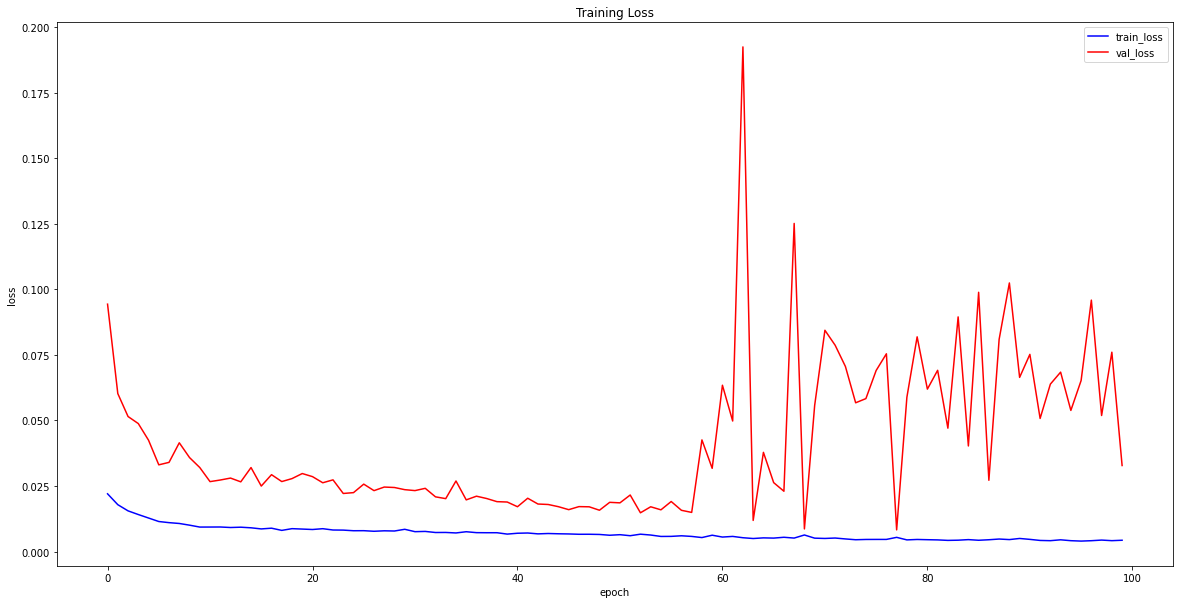

In [249]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [250]:
from keras.models import load_model
model = load_model('/content/best-model-radish.h5')

Train Data *평가*

In [251]:
model.evaluate(trainX, trainY, batch_size=a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0044 - mae: 0.0463


[0.004399060271680355, 0.046327121555805206]

In [252]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [253]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1428, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1428, 1)
(1428, 1)


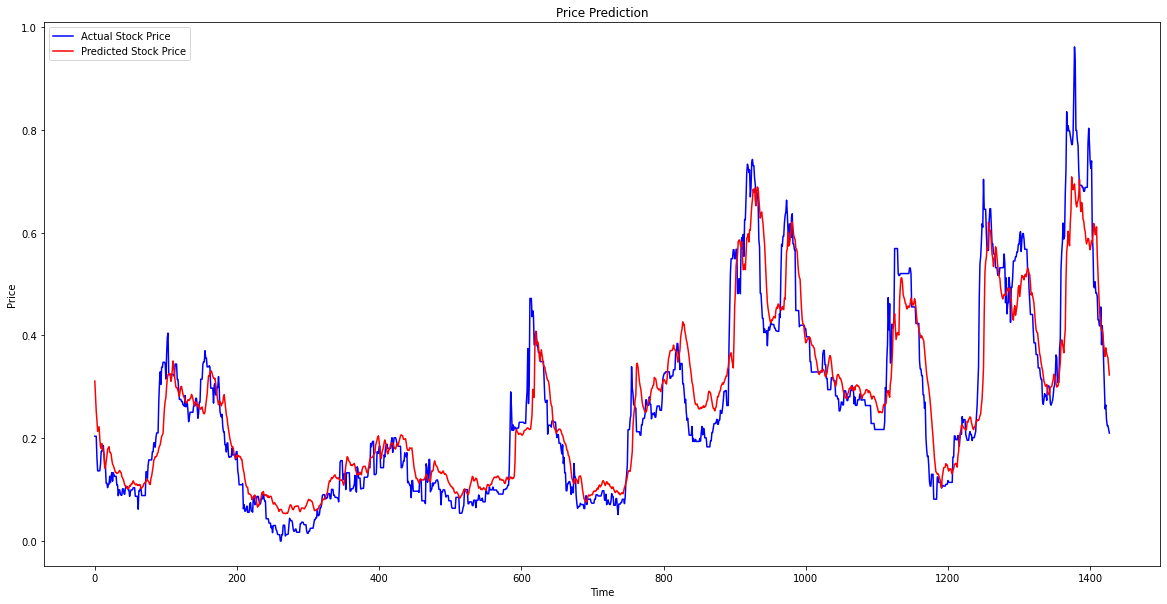

In [254]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [255]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[2115.3398]
 [2009.6182]
 [1914.4097]
 ...
 [2270.428 ]
 [2216.7559]
 [2155.8784]] (1428, 1)
[[1747.]
 [1747.]
 [1747.]
 ...
 [1818.]
 [1793.]
 [1768.]] (1428, 1)


In [256]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

227.95778149615234

In [257]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

159.24985553303353

Val Date 평가


In [258]:
model.evaluate(validX, validY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0083 - mae: 0.0697


[0.00826235767453909, 0.06967298686504364]

In [259]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


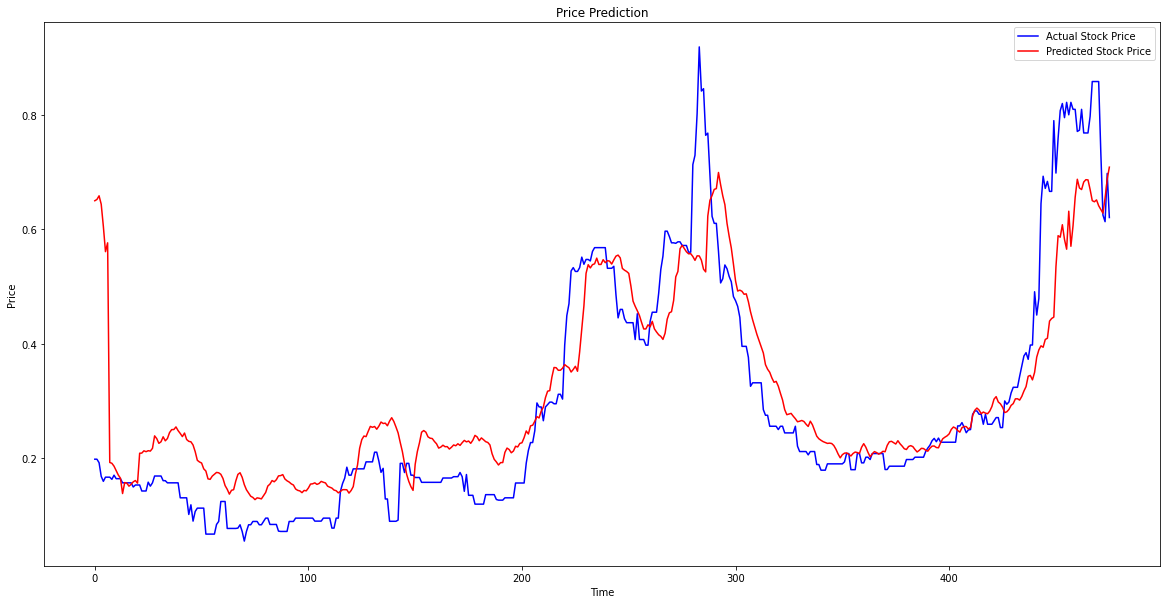

In [260]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (476, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [261]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[3278.7422]
 [3286.5818]
 [3308.4487]
 [3258.0693]
 [3125.3909]
 [2972.9565]
 [3025.9473]
 [1706.4904]
 [1701.338 ]
 [1684.0859]
 [1657.0756]
 [1630.8291]
 [1612.0679]
 [1519.7042]
 [1585.6908]
 [1582.1302]
 [1563.9249]
 [1574.9252]
 [1590.1023]
 [1597.8657]
 [1582.2128]
 [1761.9651]
 [1762.6515]
 [1776.3695]
 [1771.1658]
 [1777.0597]
 [1774.7688]
 [1791.193 ]
 [1866.148 ]
 [1849.6316]
 [1821.2411]
 [1830.7466]
 [1860.4994]
 [1836.458 ]
 [1850.2427]
 [1885.9324]
 [1903.8334]
 [1904.113 ]
 [1919.9719]
 [1897.6572]
 [1880.7432]
 [1861.7784]
 [1883.1956]
 [1844.2247]
 [1833.2659]
 [1830.5717]
 [1811.3608]
 [1771.4229]
 [1719.3484]
 [1709.5139]
 [1702.9819]
 [1668.0153]
 [1654.8862]
 [1607.8613]
 [1604.9761]
 [1624.5444]
 [1635.6462]
 [1646.5239]
 [1644.3536]
 [1635.2921]
 [1610.383 ]
 [1567.468 ]
 [1544.9962]
 [1516.2062]
 [1539.1885]
 [1542.8386]
 [1594.6566]
 [1634.7468]
 [1644.6293]
 [1617.1168]
 [1573.1569]
 [1542.2383]
 [1523.4519]
 [1503.4978]
 [1496.3033]
 [1483.0912]
 [1493.82  ]

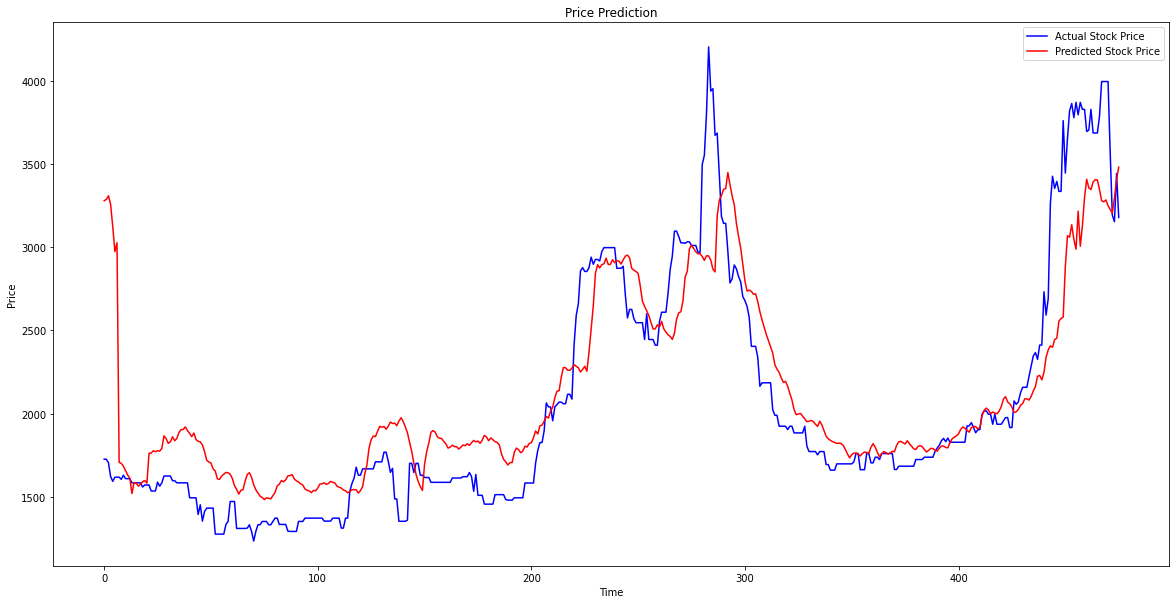

In [262]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [263]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

352.63907558503627

In [264]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

245.37363517184218

Test Data 평가

In [265]:
model.evaluate(testX, testY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0223 - mae: 0.1303


[0.02230283059179783, 0.1302882432937622]

In [266]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

68/68 [==============================] - 0s 3ms/step


(476, 1)
(476, 1)


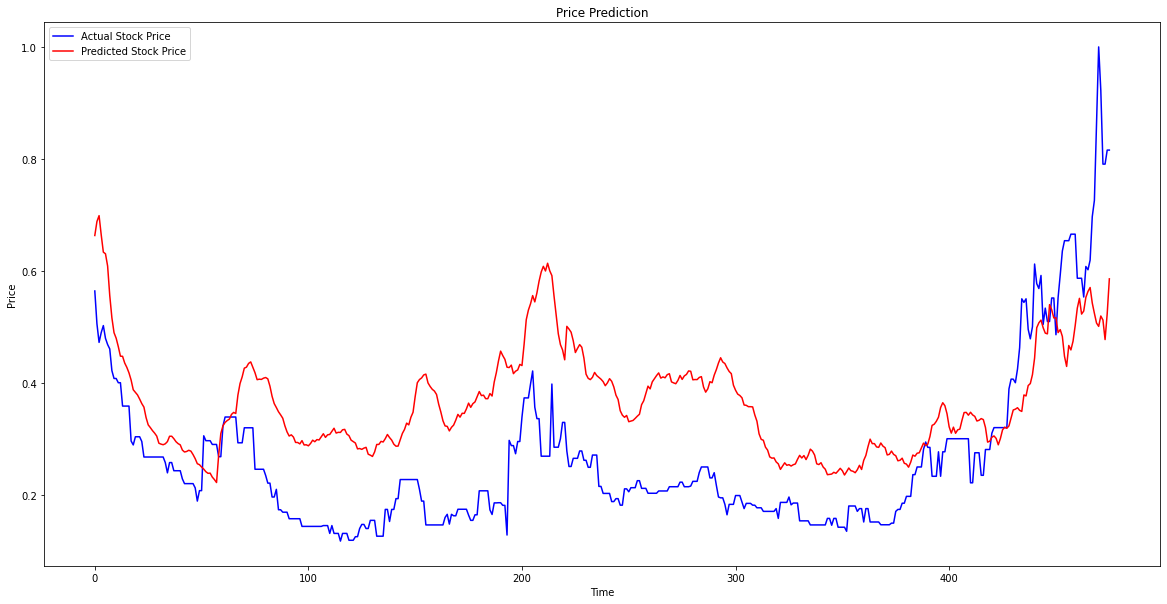

In [267]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (476, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [268]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[3324.7903]
 [3410.5918]
 [3446.5093]
 [3329.2864]
 [3222.9285]
 [3212.8052]
 [3137.9915]
 [2957.2893]
 [2820.7913]
 [2729.5784]
 [2695.6353]
 [2644.2407]
 [2585.6235]
 [2584.8794]
 [2543.6821]
 [2517.044 ]
 [2483.4814]
 [2439.424 ]
 [2380.0303]
 [2364.2385]
 [2348.1975]
 [2322.8547]
 [2295.1885]
 [2273.6218]
 [2209.8625]
 [2165.0527]
 [2148.1682]
 [2129.7505]
 [2114.4844]
 [2096.017 ]
 [2052.559 ]
 [2046.9402]
 [2043.234 ]
 [2048.9758]
 [2062.4392]
 [2095.0308]
 [2095.3535]
 [2080.4705]
 [2061.981 ]
 [2049.9912]
 [2042.4872]
 [2010.5249]
 [1998.7487]
 [2002.0416]
 [2009.3052]
 [2003.8525]
 [1982.8435]
 [1957.8964]
 [1926.9735]
 [1921.0254]
 [1906.6332]
 [1893.8127]
 [1877.8634]
 [1868.216 ]
 [1869.2463]
 [1845.1567]
 [1829.794 ]
 [1811.7094]
 [1980.9481]
 [2111.7957]
 [2159.1572]
 [2179.9587]
 [2191.435 ]
 [2200.0037]
 [2228.9683]
 [2241.0364]
 [2234.6538]
 [2347.3115]
 [2418.2883]
 [2459.043 ]
 [2512.3542]
 [2518.2783]
 [2541.2163]
 [2550.4358]
 [2516.8936]
 [2484.4014]
 [2441.6907]

In [269]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

514.7296507598028

In [270]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

449.8253822647223

예측방법

In [271]:
minX1 = np.array(dataX[0:7])
minX2 = np.array(dataX[0:8])
minX3 = np.array(dataX[0:2380])
minX4 = np.array(dataX[0:train_size])

In [272]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [273]:
predicted_price_min1[0]

array([[0.55642664],
       [0.47753882],
       [0.40322638],
       [0.34304637],
       [0.28391767],
       [0.24465334],
       [0.21893345]], dtype=float32)

In [274]:
predicted_price_min2[0]

array([[0.20847033],
       [0.2121188 ],
       [0.2107987 ],
       [0.20441023],
       [0.19320302],
       [0.191921  ],
       [0.1890614 ]], dtype=float32)

In [275]:
predicted_price_min3[0]

array([[0.16747868],
       [0.19562116],
       [0.20631039],
       [0.20862179],
       [0.20524153],
       [0.204211  ],
       [0.20041123]], dtype=float32)

In [276]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[2957.2126],
       [2686.3906],
       [2431.2761],
       [2224.6782],
       [2021.6893],
       [1886.8949],
       [1798.5985]], dtype=float32)